In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

In [2]:
import sys
import os
sys.path.append(os.path.join("..", "src"))

In [3]:
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import re
import os
import sys
import subprocess
import logging
import itertools
from sklearn import metrics
from collections import defaultdict
from IPython.display import HTML, Image, display
import ipywidgets as widgets

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S', stream=sys.stdout)
sns.set(style="white", font_scale=1.5)

In [4]:
from common import compute_nmae, prediction_params

In [5]:
train_test = pd.read_hdf("../data/interim/train_test.hdf5", "train_test")
train_test_d = pd.read_hdf("../data/interim/train_test.hdf5", "train_test_d")
INPUT_FILENAME = "../data/processed/train_test.hdf5"
train = pd.read_hdf(INPUT_FILENAME, "train")
validate = pd.read_hdf(INPUT_FILENAME, "validate")
test = pd.read_hdf(INPUT_FILENAME, "test")
submission = pd.read_hdf(INPUT_FILENAME, "submission")
meta = pd.read_hdf(INPUT_FILENAME, "meta")
test = test.join(submission.groupby('series_id')['prediction_window'].first(), on='series_id', how='left')

In [6]:
n = len(submission)
adj = {}
wi = {}
weekdays = {}
for prediction_window in ['hourly', 'daily', 'weekly']:
    cs_range = range(1, 8)
    params = prediction_params(prediction_window)
    for cs in cs_range:
        model_name = f"model_{prediction_window}_cs{cs:02d}"
        curr = test
        #curr = test.join(
        #    submission.groupby('series_id')['prediction_window'].first(),
        #    on='series_id', how='left'
        #)
        curr = curr[
            ((curr.cold_start_days == cs) if cs < max(cs_range) else (curr.cold_start_days >= cs))
            & (curr.prediction_window==prediction_window)
        ]
        assert curr.series_id.nunique() == len(curr)
        m = len(curr)
        adj[model_name] = m * params['prediction_count'] / n
        wi[model_name] = params['wi']
        g = curr.groupby(curr.timestamp.dt.dayofweek).series_id.nunique()
        g = g.reindex(range(7)).fillna(0)
        weekdays[model_name] = g

In [7]:
def sample_nmaes(data, y_pred, y_true, model_name):
    nmaes = []
    for i in range(0, 20):
        if i == 0:
            sel = data
        else:
            sel = data.sample(frac=0.5, random_state=i)
        sel_nmae = compute_nmae(y_pred.loc[sel.index], y_true.loc[sel.index], sel['ci'] / wi[model_name])
        nmaes.append(sel_nmae)
    return nmaes

def sample_nmaes_ver2(data, y_pred, y_true, model_name, k=10):
    nmaes = []
    w = model_name.split("_")[1]
    cs = int(model_name.split("cs")[1], 10)
    sel_test = test[test.prediction_window==w]
    if cs == 7:
        assert "cs07" in model_name
        dates = sel_test[sel_test.cold_start_days>=cs]['date'].drop_duplicates()
    else:
        assert "cs07" not in model_name
        dates = sel_test[sel_test.cold_start_days==cs]['date'].drop_duplicates()
    for i in range(0, 20):
        if i == 0:
            sel = data
        else:
            sel = data.sample(frac=0.5, random_state=i)
        ci = sel['ci'] / wi[model_name]
        a_len = sel['date'].isin(dates).sum()
        b_len = len(sel) - a_len
        alpha = len(sel) * k / (k * a_len + b_len)
        beta = len(sel) / (k * a_len + b_len)
        ci = ci * sel['date'].isin(dates).map({False: beta, True: alpha})
        sel_nmae = compute_nmae(y_pred.loc[sel.index], y_true.loc[sel.index], ci)
        nmaes.append(sel_nmae)
    return nmaes


def read_validation(dirname, k=4):
    res = {}
    total_nmae = 0.0
    total_nmae_max = 0.0
    total_by_window = defaultdict(float)
    std_by_key = defaultdict(float)
    total_max_by_window = defaultdict(float)
    s_key = lambda x: x.replace("daily", "01").replace("hourly", "00").replace("weekly", "02")
    for fn in sorted(os.listdir(dirname), key=s_key):
        m = re.match('(model_.*)_validate.hdf5', fn)
        if m:
            model_name = m.group(1)
            prediction_window = model_name.split("_")[1]
            full_fn = os.path.join(dirname, fn)
            data = pd.read_hdf(full_fn, "data")
            y_pred = pd.read_hdf(full_fn, "y_pred")
            y_true = pd.read_hdf(full_fn, "y_true")
            nmaes = sample_nmaes_ver2(data, y_pred, y_true, model_name, k=k)
            nmae = np.mean(nmaes)
            f = lambda x: x * adj[model_name] * wi[model_name]
            total_nmae += f(nmae)
            std_by_key['total'] += f(np.std(nmaes))
            std_by_key[prediction_window] += f(np.std(nmaes))
            total_nmae_max += f(np.max(nmaes))
            total_by_window[prediction_window] += f(nmae)
            total_max_by_window[prediction_window] += f(np.max(nmaes))

            err = (y_pred - y_true).abs()
            err = err.multiply(data['ci'], axis=0)
            err_by_series = pd.concat([
                data['series_id'],
                data['timestamp'],
                err.mean(axis=1).rename("err")
            ], axis=1).sort_values(by='err', ascending=False)
            print(f"{model_name:20}, nmae={nmae:.6f}..{np.max(nmaes):.6f}, nmae_dev={np.std(nmaes):.6f}"
                  f" total_nmae={total_nmae:.6f}, total_nmae_max={total_nmae_max:.6f}")
            res[model_name] = {
                'data': data,
                'y_pred': y_pred,
                'y_true': y_true,
                'nmae': nmae,
                'err_by_series': err_by_series
            }
    print(
        f"[AVG] total={total_nmae:.6f}"
        f" total[hourly]={total_by_window['hourly']:.6f} "
        f" total[daily]={total_by_window['daily']:.6f} "
        f" total[weekly]={total_by_window['weekly']:.6f} "
    )
    print(
        f"[STD]   std={std_by_key['total']:.6f}"
        f"   std[hourly]={std_by_key['hourly']:.6f} "
        f"   std[daily]={std_by_key['daily']:.6f} "
        f"   std[weekly]={std_by_key['weekly']:.6f} "
    )
    print(
        f"[MAX] total={total_nmae_max:.6f}"
        f" total[hourly]={total_max_by_window['hourly']:.6f} "
        f" total[daily]={total_max_by_window['daily']:.6f} "
        f" total[weekly]={total_max_by_window['weekly']:.6f} "
    )
    return res

# load data from prediction_twalen_0.2851

In [8]:
v = read_validation("../models/prediction_twalen_0.2851")

model_hourly_cs01   , nmae=0.188227..0.193240, nmae_dev=0.002551 total_nmae=0.010200, total_nmae_max=0.010472
model_hourly_cs02   , nmae=0.181876..0.189500, nmae_dev=0.005128 total_nmae=0.017737, total_nmae_max=0.018325
model_hourly_cs03   , nmae=0.210796..0.221037, nmae_dev=0.006745 total_nmae=0.031848, total_nmae_max=0.033121
model_hourly_cs04   , nmae=0.188536..0.194777, nmae_dev=0.003938 total_nmae=0.042666, total_nmae_max=0.044297
model_hourly_cs05   , nmae=0.204915..0.218256, nmae_dev=0.006324 total_nmae=0.053117, total_nmae_max=0.055429
model_hourly_cs06   , nmae=0.173796..0.179743, nmae_dev=0.003282 total_nmae=0.066413, total_nmae_max=0.069180
model_hourly_cs07   , nmae=0.151615..0.164214, nmae_dev=0.005006 total_nmae=0.130692, total_nmae_max=0.138800
model_daily_cs01    , nmae=0.148856..0.154656, nmae_dev=0.002320 total_nmae=0.141131, total_nmae_max=0.149646
model_daily_cs02    , nmae=0.148816..0.153401, nmae_dev=0.002223 total_nmae=0.148246, total_nmae_max=0.156981
model_dail

model_hourly_cs07 nmae=0.151615
worst predictions:


,err
series_id,
101530,0.790389
103364,0.733609
101457,0.711149


best predictions:


,err
series_id,
102231,0.026442
102164,0.014404
102428,0.012041


    target_f_h_000  target_f_h_001  target_f_h_002  target_f_h_003  \
36    36037.260422    33805.982007    33368.008685    35041.421619   
37    33670.118879    33214.616585    31622.172963    31994.605398   
38    33361.124896    33728.250992    31720.918299    32113.731574   

    target_f_h_004  target_f_h_005  target_f_h_006  target_f_h_007  \
36    35970.741432    37276.360759    43670.792730    49041.184470   
37    33843.318926    35927.343682    38344.690167    45070.458648   
38    33824.293810    35082.709191    40939.011678    46880.961763   

    target_f_h_008  target_f_h_009       ...        target_f_h_014  \
36    52984.891871    51345.273360       ...          47455.071862   
37    48664.606430    47600.737781       ...          43664.520105   
38    49639.708371    47462.348146       ...          45322.860831   

    target_f_h_015  target_f_h_016  target_f_h_017  target_f_h_018  \
36    49633.038036    51058.661948    51456.892442    48919.877924   
37    47358.19867

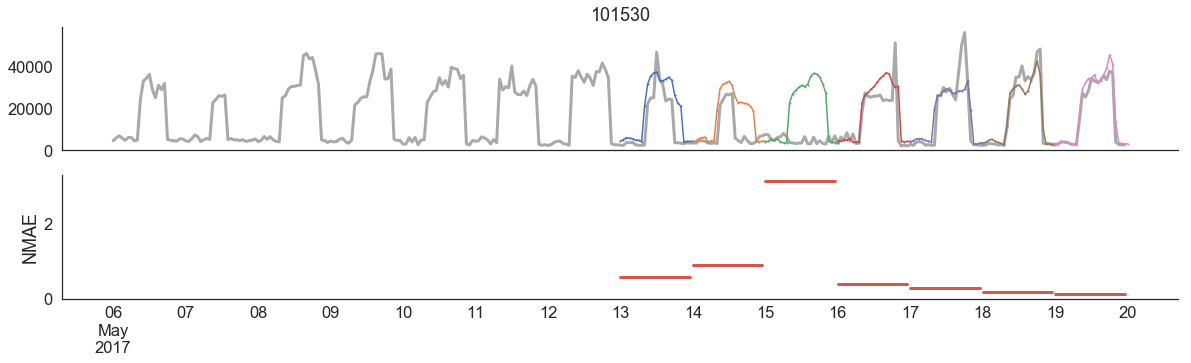

In [9]:
def show_predictions_for_model_and_series(model_name, series_id):
    vv = v[model_name]
    data = vv['data']
    y_pred = vv['y_pred']
    y_true = vv['y_true']
    sel_data = data[data.series_id==series_id]
    prediction_window = sel_data.iloc[0].prediction_window
    print(y_pred.head(3))

    if prediction_window == 'hourly':
        val_data = train_test[(train_test.series_id==series_id) & (train_test.entry_type.isin(['train', 'cold_start']))]
    else:
        val_data = train_test_d[(train_test_d.series_id==series_id) & (train_test_d.entry_type.isin(['train', 'cold_start']))]
    params = prediction_params(prediction_window)

    fig, axs = plt.subplots(figsize=(20, 5), nrows=2, sharex=True) 
    ax = axs[0]
    
    min_date = val_data['timestamp'].min()
    max_date = val_data['timestamp'].max()
    print(min_date, max_date)
    val_data.groupby('timestamp')['consumption'].first().plot(
        ax=ax, kind='line', 
        color=sns.xkcd_rgb['grey'], linewidth=3, alpha=0.8, legend=None
    )
    ax.set_ylim(0)

    
    
    for i, row in sel_data.iterrows():
        t = row['timestamp']
        dt = pd.DateOffset(hours=params['prediction_agg'])
        index = pd.date_range(row['timestamp'], periods=params['prediction_count'] + 1, freq=dt).tolist()
        index0 = pd.date_range(row['timestamp'], periods=params['prediction_count'], freq=dt).tolist()
        y = y_pred.loc[i].values
        y = np.append(y, y[-1])
        if prediction_window=='weekly':
            y = y / 7
        
        if index[0] > min_date:
            index = [min_date] + index
            y = np.append([None], y)
        if index[-1] < max_date:
            index = index + [max_date]
            y = np.append(y, [None])
        
        s = pd.Series(
            y, 
            index=index
        )
        s.plot(ax=ax, kind='line', marker='o', ms=1)
        d = pd.Series(
            np.mean((y_pred.loc[i] - y_true.loc[i]).abs().values * row['ci']),
            index=index0
        )
        d.plot(ax=axs[1], kind='line', color=sns.xkcd_rgb['pale red'], linewidth=3)
    axs[1].set_ylim(0, None)
    axs[1].set_ylabel("NMAE")
        
    sns.despine(ax=axs[0])
    sns.despine(ax=axs[1])
    axs[0].set_title(str(series_id))
    plt.show()

def show_validation_for_model(model_name):
    vv = v[model_name]
    print(f"{model_name} nmae={vv['nmae']:.6f}")
    e = vv['err_by_series'].groupby('series_id')['err'].mean().sort_values(ascending=False)
    print("worst predictions:")
    display(e.to_frame().head(3))
    print("best predictions:")
    display(e.to_frame().tail(3))
    show_predictions_for_model_and_series(model_name, e.index[0])

show_validation_for_model("model_hourly_cs07")

27


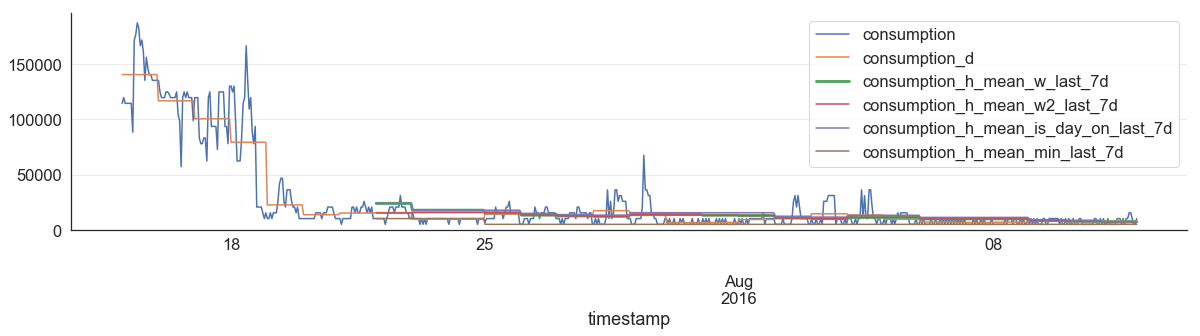

27


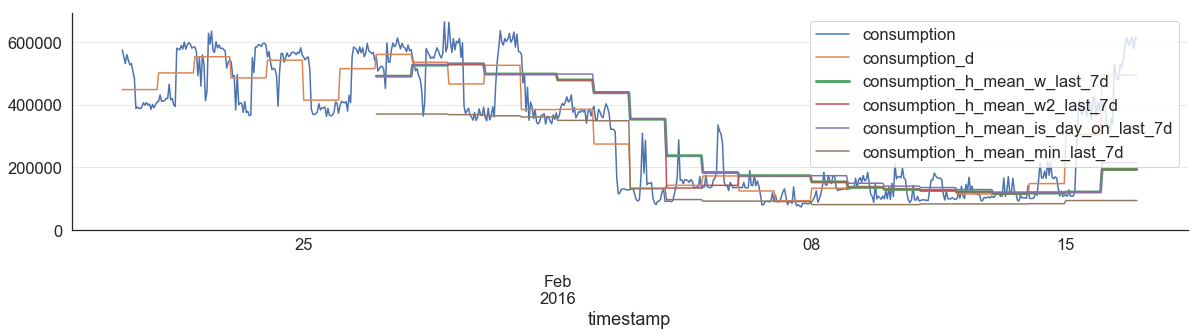

In [10]:

def show_series_consumption(series_id=101057):
    v_data = train[train.series_id==series_id]
    data = train_test[(train_test.series_id==series_id) & (train_test.entry_type.isin(['train', 'cold_start']))].copy()
    data = data.merge(
        v_data[['date', 'consumption_h_mean_w_last_7d', 'consumption_h_mean_w2_last_7d', 
                'consumption_h_mean_is_day_on_last_7d', 'consumption_h_mean_min_last_7d']],
        on=['date'], how='left'
    )
    print(len(v_data))
    fig, ax = plt.subplots(figsize=(20, 4))
    data.plot(kind='line', ax=ax, x='timestamp', y='consumption')
    data['consumption_d'] = data.groupby('date')['consumption'].transform(np.mean)
    data.plot(kind='line', ax=ax, x='timestamp', y='consumption_d')
    data.plot(kind='line', ax=ax, x='timestamp', y='consumption_h_mean_w_last_7d', linewidth=3)
    data.plot(kind='line', ax=ax, x='timestamp', y='consumption_h_mean_w2_last_7d')
    data.plot(kind='line', ax=ax, x='timestamp', y='consumption_h_mean_is_day_on_last_7d')
    data.plot(kind='line', ax=ax, x='timestamp', y='consumption_h_mean_min_last_7d')
    ax.set_ylim(0)
    ax.yaxis.grid(True, alpha=0.4)
    sns.despine(ax=ax)
    plt.show()
    
    
    
    #ax = data['consumption'].rolling(window=24).mean().plot(figsize=(10, 4))
    #ax.set_ylim(0)
    
show_series_consumption()
show_series_consumption(102214)


0


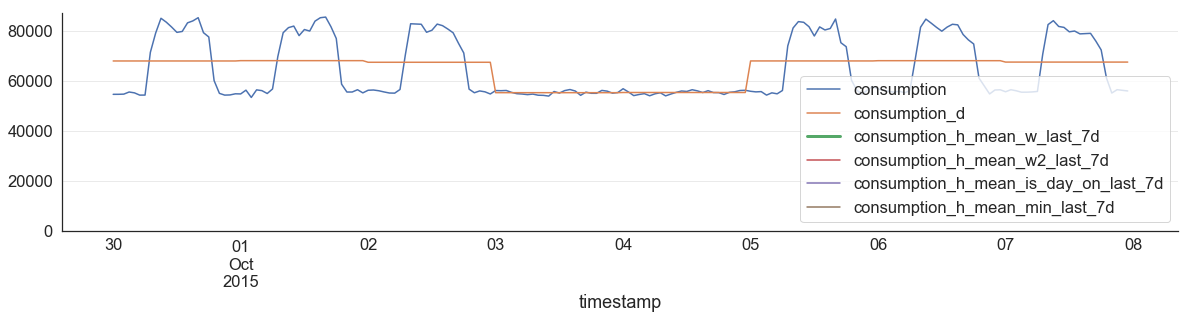

In [12]:
show_series_consumption(102164)